## Demonstrate full circle wide field imaging

This include prediction of components, inversion, point source fitting. We will compare the output images with the input models, looking for closeness in flux and position.

In [1]:
% matplotlib inline

import os
import sys

results_dir = './results'
os.makedirs(results_dir, exist_ok=True)

sys.path.append(os.path.join('..', '..'))

from matplotlib import pylab

pylab.rcParams['figure.figsize'] = (10.0, 10.0)
pylab.rcParams['image.cmap'] = 'rainbow'

import numpy

from astropy.coordinates import SkyCoord
from astropy.time import Time
from astropy import units as u
from astropy.wcs.utils import pixel_to_skycoord

from arl.visibility.base import create_visibility
from arl.visibility.operations import sum_visibility
from arl.visibility.iterators import vis_timeslice_iter
from arl.util.testing_support import create_named_configuration
from arl.util.timing import timing

from matplotlib import pyplot as plt

from arl.skycomponent.operations import create_skycomponent, find_skycomponents, \
    find_nearest_component, insert_skycomponent
from arl.image.operations import show_image, export_image_to_fits, qa_image, smooth_image
from arl.image.iterators import  image_raster_iter
from arl.util.testing_support import create_named_configuration
from arl.imaging import advise_wide_field, predict_2d, predict_wstack, predict_timeslice, predict_facets, \
    predict_wprojection, invert_wstack, invert_2d, invert_timeslice, invert_facets, invert_wprojection, \
    create_image_from_visibility, predict_skycomponent_visibility
from arl.data.polarisation import PolarisationFrame

import logging

log = logging.getLogger()
log.setLevel(logging.DEBUG)
log.addHandler(logging.StreamHandler(sys.stdout))

Construct the SKA1-LOW core configuration

In [2]:
lowcore = create_named_configuration('LOWBD2-CORE')

We create the visibility. This just makes the uvw, time, antenna1, antenna2, weight columns in a table

In [3]:
times = numpy.array([-3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0]) * (numpy.pi / 12.0)
frequency = numpy.array([1e8])
channel_bandwidth = numpy.array([1e6])
reffrequency = numpy.max(frequency)
phasecentre = SkyCoord(ra=+15.0 * u.deg, dec=-45.0 * u.deg, frame='icrs', equinox='J2000')
vt = create_visibility(lowcore, times, frequency, channel_bandwidth=channel_bandwidth,
                       weight=1.0, phasecentre=phasecentre, 
                       polarisation_frame=PolarisationFrame('stokesI'))

create_visibility: 95865 rows, 0.010 GB


In [4]:
advice = advise_wide_field(vt, wprojection_planes=1)

advise_wide_field: Maximum wavelength 2.998 (meters)
advise_wide_field: Minimum wavelength 2.998 (meters)
advise_wide_field: Maximum baseline 262.6 (wavelengths)
advise_wide_field: Station/antenna diameter 35.0 (meters)
advise_wide_field: Primary beam 0.085655 (rad) 4.908 (deg)
advise_wide_field: Image field of view 0.513930 (rad) 29.446 (deg)
advise_wide_field: Synthesized beam 0.003808 (rad) 0.218 (deg)
advise_wide_field: Cellsize 0.001269 (rad) 0.073 (deg)
advice_wide_field: Npixels per side = 405
advice_wide_field: Npixels (power of 2, 3) per side = 512
advice_wide_field: W sampling for full image = 0.2 (wavelengths)
advice_wide_field: W sampling for primary beam = 8.7 (wavelengths)
advice_wide_field: Time sampling for full image = 25.2 (s)
advice_wide_field: Time sampling for primary beam = 908.6 (s)
advice_wide_field: Frequency sampling for full image = 29212.6 (Hz)
advice_wide_field: Frequency sampling for primary beam = 1051653.8 (Hz)
advice_wide_field: Number of planes in w st

Fill in the visibility with exact calculation of a number of point sources

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>, starting frequency 100000000.0 Hz, and bandwidth 1000000.0 Hz
create_image_from_visibility: uvmax = 262.634709 wavelengths
create_image_from_visibility: Critical cellsize = 0.001904 radians, 0.109079 degrees
create_image_from_visibility: Cellsize          = 0.001000 radians, 0.057296 degrees
Spacing in pixels = 32
[-2.88457684 -1.9498827  -1.34510001 -1.08699559  0.0355264   0.34530405
  0.44505024  3.67267451]
insert_skycomponent: Using insert method Nearest
insert_skycomponent: Using insert method Nearest
insert_skycomponent: Using insert method Nearest
insert_skycomponent: Using insert method Nearest
insert_skycomponent: Using insert method Nearest
insert_skycomponent: Using insert method Nearest
insert_skycomponent: Using insert method Nearest
insert_skycomponent: Using insert method Nearest
in

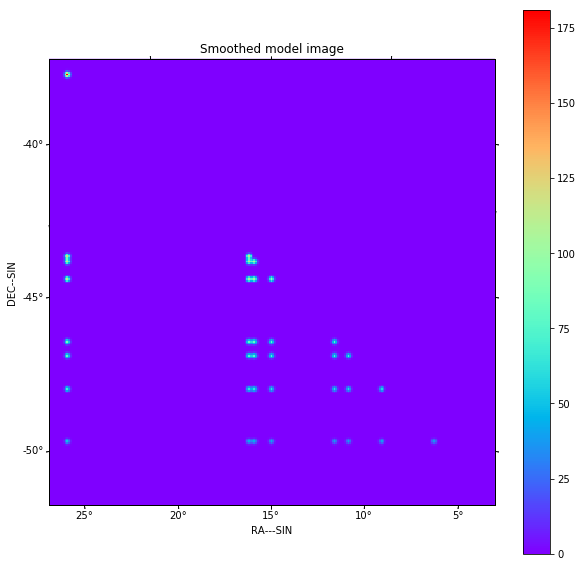

In [5]:
vt.data['vis'] *= 0.0
npixel=256

model = create_image_from_visibility(vt, npixel=npixel, cellsize=0.001, nchan=1, 
                                     polarisation_frame=PolarisationFrame('stokesI'))
centre = model.wcs.wcs.crpix-1
spacing_pixels = npixel // 8
log.info('Spacing in pixels = %s' % spacing_pixels)
spacing = model.wcs.wcs.cdelt * spacing_pixels
# locations = [-3.5, -2.5, -1.5, -0.5, 0.5, 1.5, 2.5, 3.5]
locations = numpy.sort(numpy.random.rand(8) * 8 - 4)
print(locations)

original_comps = []
# We calculate the source positions in pixels and then calculate the
# world coordinates to put in the skycomponent description
for iy in locations:
    for ix in locations:
        if ix >= iy:
            p = int(round(centre[0] + ix * spacing_pixels * numpy.sign(model.wcs.wcs.cdelt[0]))), \
                int(round(centre[1] + iy * spacing_pixels * numpy.sign(model.wcs.wcs.cdelt[1])))
            sc = pixel_to_skycoord(p[0], p[1], model.wcs)
#             log.info("Component at (%f, %f) [0-rel] %s" % (p[0], p[1], str(sc)))
            flux = numpy.array([[100.0 + 2.0 * ix + iy * 20.0]])
            comp = create_skycomponent(flux=flux, frequency=frequency, direction=sc, 
                                       polarisation_frame=PolarisationFrame('stokesI'))
            original_comps.append(comp)
            insert_skycomponent(model, comp)

predict_skycomponent_visibility(vt, original_comps)

        
cmodel = smooth_image(model) 
show_image(cmodel)
plt.title("Smoothed model image")
plt.show()

Check that the skycoordinate and image coordinate system are consistent by finding the point sources.

find_skycomponents: Finding components in Image by segmentation
find_skycomponents: Identified 28 segments


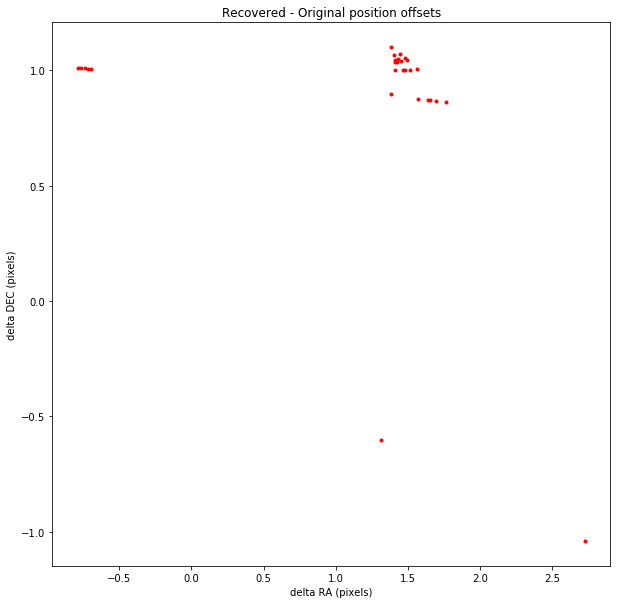

In [6]:
comps = find_skycomponents(cmodel, fwhm=1.0, threshold=10.0, npixels=5)
plt.clf()
for i in range(len(comps)):
    ocomp = find_nearest_component(comps[i].direction, original_comps)
    plt.plot((comps[i].direction.ra.value  - ocomp.direction.ra.value)/cmodel.wcs.wcs.cdelt[0], 
             (comps[i].direction.dec.value - ocomp.direction.dec.value)/cmodel.wcs.wcs.cdelt[1], 
             '.', color='r')  

plt.xlabel('delta RA (pixels)')
plt.ylabel('delta DEC (pixels)')
plt.title("Recovered - Original position offsets")
plt.show()

Predict the visibility using the different approaches.

create_visibility: 95865 rows, 0.010 GB
predict_2d: predict using 2d transform
vis: complex128 (95865, 1)
kernels_c: complex128 (1, 4, 4, 8, 8)
kernel_indices_c: int32 (95865,)
uvgrid: complex128 (1, 1, 512, 512)
vuvwmap: float64 (95865, 3)
vfrequencymap_c: int32 (95865,)
convolutional_degrid time: 2.5508s
freq : 0.0298s
fft  : 0.0317s
grid : 2.5561s
shift: 0.1578s
func:'predictit' took: 2.7876 sec


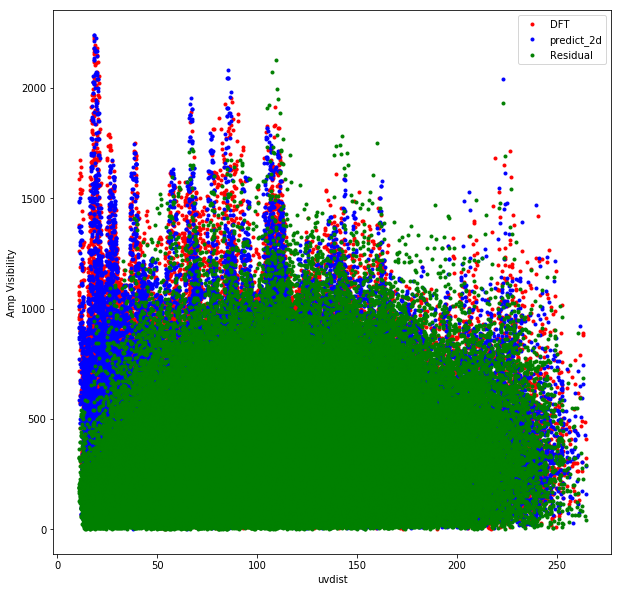

create_visibility: 95865 rows, 0.010 GB
predict_wstack: predicting using wstack
predict_with_vis_iterator: Processing chunks
predict_wstack_single: predicting using single w slice
create_w_term_image: For w = -155.5, field of view = 0.256000, Fresnel number = 2.55
vis: complex128 (14, 1)
kernels_c: complex128 (1, 4, 4, 8, 8)
kernel_indices_c: int32 (14,)
uvgrid: complex128 (1, 1, 512, 512)
vuvwmap: float64 (14, 3)
vfrequencymap_c: int32 (14,)
convolutional_degrid time: 0.0048s
freq : 0.0162s
fft  : 0.0284s
grid : 0.0053s
shift: 0.1590s
vis: complex128 (14, 1)
kernels_c: complex128 (1, 4, 4, 8, 8)
kernel_indices_c: int32 (14,)
uvgrid: complex128 (1, 1, 512, 512)
vuvwmap: float64 (14, 3)
vfrequencymap_c: int32 (14,)
convolutional_degrid time: 0.0050s
freq : 0.0179s
fft  : 0.0259s
grid : 0.0054s
shift: 0.1594s
predict_wstack_single: predicting using single w slice
create_w_term_image: For w = -145.6, field of view = 0.256000, Fresnel number = 2.39
vis: complex128 (66, 1)
kernels_c: comple

convolutional_degrid time: 0.1906s
freq : 0.0165s
fft  : 0.0305s
grid : 0.1912s
shift: 0.1607s
vis: complex128 (6948, 1)
kernels_c: complex128 (1, 4, 4, 8, 8)
kernel_indices_c: int32 (6948,)
uvgrid: complex128 (1, 1, 512, 512)
vuvwmap: float64 (6948, 3)
vfrequencymap_c: int32 (6948,)
convolutional_degrid time: 0.1911s
freq : 0.0169s
fft  : 0.0297s
grid : 0.1917s
shift: 0.1596s
predict_wstack_single: predicting using single w slice
create_w_term_image: For w = -22.5, field of view = 0.256000, Fresnel number = 0.37
vis: complex128 (8453, 1)
kernels_c: complex128 (1, 4, 4, 8, 8)
kernel_indices_c: int32 (8453,)
uvgrid: complex128 (1, 1, 512, 512)
vuvwmap: float64 (8453, 3)
vfrequencymap_c: int32 (8453,)
convolutional_degrid time: 0.2313s
freq : 0.0161s
fft  : 0.0318s
grid : 0.2320s
shift: 0.1602s
vis: complex128 (8453, 1)
kernels_c: complex128 (1, 4, 4, 8, 8)
kernel_indices_c: int32 (8453,)
uvgrid: complex128 (1, 1, 512, 512)
vuvwmap: float64 (8453, 3)
vfrequencymap_c: int32 (8453,)
convol

create_w_term_image: For w = 101.4, field of view = 0.256000, Fresnel number = 1.66
vis: complex128 (900, 1)
kernels_c: complex128 (1, 4, 4, 8, 8)
kernel_indices_c: int32 (900,)
uvgrid: complex128 (1, 1, 512, 512)
vuvwmap: float64 (900, 3)
vfrequencymap_c: int32 (900,)
convolutional_degrid time: 0.0290s
freq : 0.0163s
fft  : 0.0288s
grid : 0.0292s
shift: 0.1589s
vis: complex128 (900, 1)
kernels_c: complex128 (1, 4, 4, 8, 8)
kernel_indices_c: int32 (900,)
uvgrid: complex128 (1, 1, 512, 512)
vuvwmap: float64 (900, 3)
vfrequencymap_c: int32 (900,)
convolutional_degrid time: 0.0287s
freq : 0.0180s
fft  : 0.0262s
grid : 0.0288s
shift: 0.1596s
predict_wstack_single: predicting using single w slice
create_w_term_image: For w = 112.7, field of view = 0.256000, Fresnel number = 1.85
vis: complex128 (563, 1)
kernels_c: complex128 (1, 4, 4, 8, 8)
kernel_indices_c: int32 (563,)
uvgrid: complex128 (1, 1, 512, 512)
vuvwmap: float64 (563, 3)
vfrequencymap_c: int32 (563,)
convolutional_degrid time: 0.

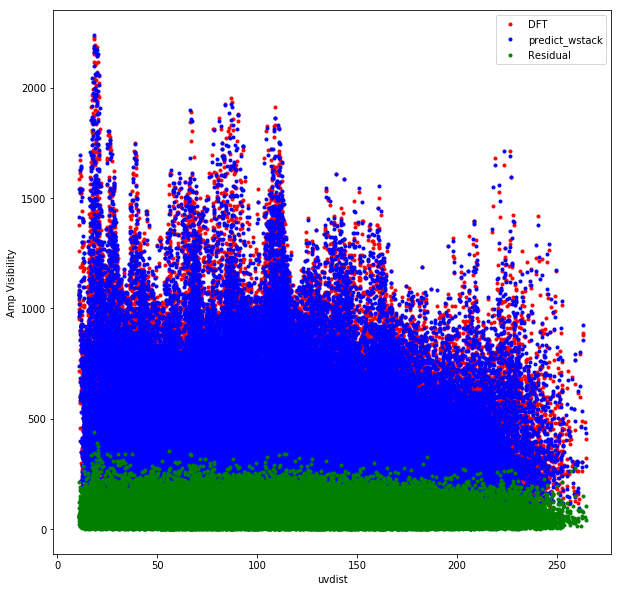

create_visibility: 95865 rows, 0.010 GB
predict_timeslice: predicting using time slices
predict_with_vis_iterator: Processing chunks
predict_timeslice_single: predicting using single time slice
fit_uvwplane: Fit to 13695 rows reduces rms w from 59.6 to 0.0 m
vis: complex128 (13695, 1)
kernels_c: complex128 (1, 4, 4, 8, 8)
kernel_indices_c: int32 (13695,)
uvgrid: complex128 (1, 1, 512, 512)
vuvwmap: float64 (13695, 3)
vfrequencymap_c: int32 (13695,)
convolutional_degrid time: 0.3679s
freq : 0.0163s
fft  : 0.0325s
grid : 0.3688s
shift: 0.1575s
predict_timeslice_single: predicting using single time slice
fit_uvwplane: Fit to 13695 rows reduces rms w from 46.1 to 0.0 m
vis: complex128 (13695, 1)
kernels_c: complex128 (1, 4, 4, 8, 8)
kernel_indices_c: int32 (13695,)
uvgrid: complex128 (1, 1, 512, 512)
vuvwmap: float64 (13695, 3)
vfrequencymap_c: int32 (13695,)
convolutional_degrid time: 0.3699s
freq : 0.0173s
fft  : 0.0287s
grid : 0.3707s
shift: 0.1578s
predict_timeslice_single: predicting 

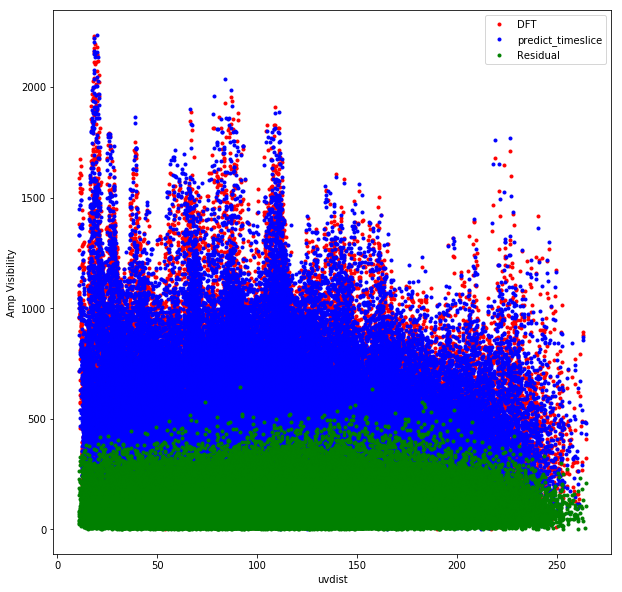

create_visibility: 95865 rows, 0.010 GB
predict_facets: Predicting by image facets
predict_with_image_iterator: Predicting by image partitions
raster: predicting using 8 x 8 image partitions
raster: spacing of raster (32, 32)
raster: partition (0, 0) of (8, 8)
vis: complex128 (95865, 1)
kernels_c: complex128 (1, 4, 4, 8, 8)
kernel_indices_c: int32 (95865,)
uvgrid: complex128 (1, 1, 64, 64)
vuvwmap: float64 (95865, 3)
vfrequencymap_c: int32 (95865,)
convolutional_degrid time: 2.5564s
shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 25.25621708, -51.0209895)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>
freq : 0.0125s
fft  : 0.0007s
grid : 2.5616s
shift: 0.6679s
raster: partition (1, 0) of (8, 8)
vis: complex128 (95865, 1)
kernels_c: complex128 (1, 4, 4, 8, 8)
kernel_indices_c: int32 (95865,)
uvgrid: complex128 (1, 1, 64, 64)
vuvwmap: float64 (95865, 3)
vfrequencymap_c: int32 (95865,)
convolution

freq : 0.0124s
fft  : 0.0006s
grid : 2.5570s
shift: 0.6117s
raster: partition (7, 1) of (8, 8)
vis: complex128 (95865, 1)
kernels_c: complex128 (1, 4, 4, 8, 8)
kernel_indices_c: int32 (95865,)
uvgrid: complex128 (1, 1, 64, 64)
vuvwmap: float64 (95865, 3)
vfrequencymap_c: int32 (95865,)
convolutional_degrid time: 2.5633s
shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 5.13131616, -49.19566221)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>
freq : 0.0127s
fft  : 0.0007s
grid : 2.5686s
shift: 0.6089s
raster: partition (0, 2) of (8, 8)
vis: complex128 (95865, 1)
kernels_c: complex128 (1, 4, 4, 8, 8)
kernel_indices_c: int32 (95865,)
uvgrid: complex128 (1, 1, 64, 64)
vuvwmap: float64 (95865, 3)
vfrequencymap_c: int32 (95865,)
convolutional_degrid time: 2.5631s
shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 24.51939763, -47.3730574)> to visi

convolutional_degrid time: 2.5789s
shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 8.41902027, -45.73040913)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>
freq : 0.0125s
fft  : 0.0006s
grid : 2.5841s
shift: 0.6126s
raster: partition (7, 3) of (8, 8)
vis: complex128 (95865, 1)
kernels_c: complex128 (1, 4, 4, 8, 8)
kernel_indices_c: int32 (95865,)
uvgrid: complex128 (1, 1, 64, 64)
vuvwmap: float64 (95865, 3)
vfrequencymap_c: int32 (95865,)
convolutional_degrid time: 2.5467s
shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 5.79665285, -45.55152143)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>
freq : 0.0127s
fft  : 0.0007s
grid : 2.5518s
shift: 0.6138s
raster: partition (0, 4) of (8, 8)
vis: complex128 (95865, 1)
kernels_c: complex128 (1, 4, 4, 8, 8)
kernel_indices_c: int32 (95865,)
uvgrid: complex128 (1,

freq : 0.0128s
fft  : 0.0007s
grid : 2.5528s
shift: 0.6036s
raster: partition (6, 5) of (8, 8)
vis: complex128 (95865, 1)
kernels_c: complex128 (1, 4, 4, 8, 8)
kernel_indices_c: int32 (95865,)
uvgrid: complex128 (1, 1, 64, 64)
vuvwmap: float64 (95865, 3)
vfrequencymap_c: int32 (95865,)
convolutional_degrid time: 2.5904s
shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 8.81293237, -42.07336315)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>
freq : 0.0125s
fft  : 0.0007s
grid : 2.5954s
shift: 0.6101s
raster: partition (7, 5) of (8, 8)
vis: complex128 (95865, 1)
kernels_c: complex128 (1, 4, 4, 8, 8)
kernel_indices_c: int32 (95865,)
uvgrid: complex128 (1, 1, 64, 64)
vuvwmap: float64 (95865, 3)
vfrequencymap_c: int32 (95865,)
convolutional_degrid time: 2.5644s
shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 6.34489535, -41.90491964)> to visi

convolutional_degrid time: 2.5485s
shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 11.48319489, -38.50929785)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>
freq : 0.0127s
fft  : 0.0007s
grid : 2.5536s
shift: 0.6857s
raster: partition (6, 7) of (8, 8)
vis: complex128 (95865, 1)
kernels_c: complex128 (1, 4, 4, 8, 8)
kernel_indices_c: int32 (95865,)
uvgrid: complex128 (1, 1, 64, 64)
vuvwmap: float64 (95865, 3)
vfrequencymap_c: int32 (95865,)
convolutional_degrid time: 2.5301s
shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    ( 9.14080118, -38.40243471)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>
freq : 0.0123s
fft  : 0.0007s
grid : 2.5351s
shift: 0.6195s
raster: partition (7, 7) of (8, 8)
vis: complex128 (95865, 1)
kernels_c: complex128 (1, 4, 4, 8, 8)
kernel_indices_c: int32 (95865,)
uvgrid: complex128 (1

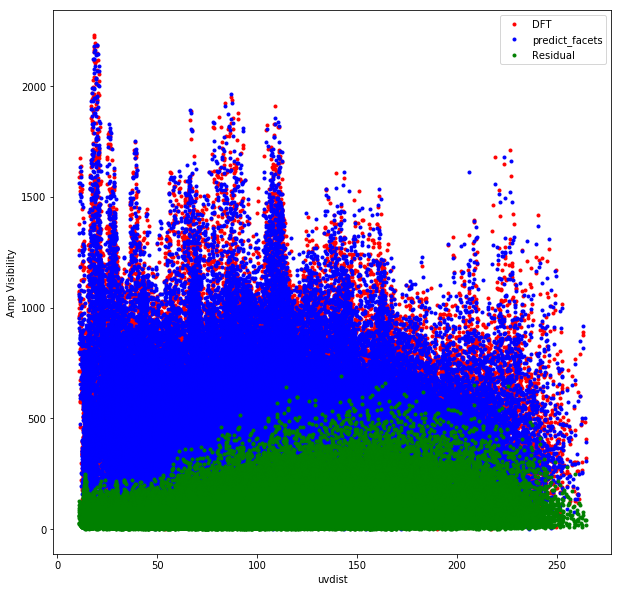

create_visibility: 95865 rows, 0.010 GB
predict_wprojection: predict using wprojection
get_kernel_list: Using wprojection kernel
get_kernel_list: Fresnel number = 16.384000
advise_wide_field: Maximum wavelength 2.998 (meters)
advise_wide_field: Minimum wavelength 2.998 (meters)
advise_wide_field: Maximum baseline 262.6 (wavelengths)
advise_wide_field: Station/antenna diameter 35.0 (meters)
advise_wide_field: Primary beam 0.085655 (rad) 4.908 (deg)
advise_wide_field: Image field of view 0.513930 (rad) 29.446 (deg)
advise_wide_field: Synthesized beam 0.003808 (rad) 0.218 (deg)
advise_wide_field: Cellsize 0.001269 (rad) 0.073 (deg)
advice_wide_field: Npixels per side = 405
advice_wide_field: Npixels (power of 2, 3) per side = 512
advice_wide_field: W sampling for full image = 0.2 (wavelengths)
advice_wide_field: W sampling for primary beam = 8.7 (wavelengths)
advice_wide_field: Time sampling for full image = 25.2 (s)
advice_wide_field: Time sampling for primary beam = 908.6 (s)
advice_wid

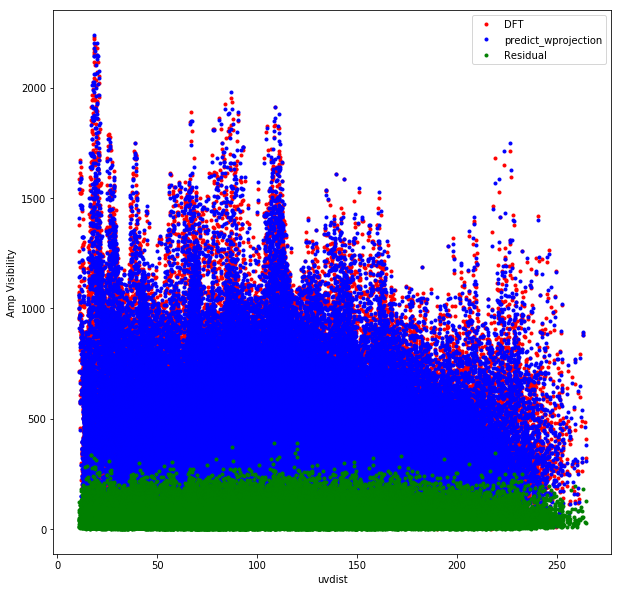

In [7]:
processors = [predict_2d, predict_wstack, predict_timeslice, predict_facets, predict_wprojection]

for processor in processors:
    
    uvdist=numpy.sqrt(vt.data['uvw'][:,0]**2+vt.data['uvw'][:,1]**2)
    plt.clf()
    plt.plot(uvdist, numpy.abs(vt.data['vis'][:]), '.', color='r', label="DFT")   
    vtpredict = create_visibility(lowcore, times, frequency, channel_bandwidth=channel_bandwidth,
                                  weight=1.0, phasecentre=phasecentre,
                                 polarisation_frame=PolarisationFrame('stokesI'))
    @timing
    def predictit():
        return processor(vtpredict, model, nprocessor=1, timeslice='auto', vis_slices=31,
                         oversampling=4, facets=8, wstep=advice['w_sampling_primary_beam'])

    vtpredict = predictit()
        
    plt.plot(uvdist, numpy.abs(vtpredict.data['vis'][:]), '.', color='b', label=processor.__name__)
    plt.plot(uvdist, numpy.abs(vtpredict.data['vis'][:]-vt.data['vis'][:]), '.', color='g', label="Residual")
    plt.xlabel('uvdist')
    plt.ylabel('Amp Visibility')
    plt.legend()
    plt.show()

Make the image using the different approaches. We will evaluate the results using a number of plots:

- The error in fitted versus the radius. The ideal result is a straightline fitted: flux = DFT flux
- The offset in RA versus the offset in DEC. The ideal result is a cluster around 0 pixels.

The sampling in w is set to provide 2% decorrelation at the half power point of the primary beam.


create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>, starting frequency 100000000.0 Hz, and bandwidth 1000000.0 Hz
create_image_from_visibility: uvmax = 262.634709 wavelengths
create_image_from_visibility: Critical cellsize = 0.001904 radians, 0.109079 degrees
create_image_from_visibility: Cellsize          = 0.001000 radians, 0.057296 degrees
invert_wstack: inverting using wstack
invert_wstack_single: predicting using single w slice
grid: 0.0010s
invert_2d_base: retaining imaginary part of dirty image
create_w_term_image: For w = -158.7, field of view = 0.256000, Fresnel number = 2.60
invert_wstack_single: predicting using single w slice
grid: 0.0015s
invert_2d_base: retaining imaginary part of dirty image
create_w_term_image: For w = -151.5, field of view = 0.256000, Fresnel number = 2.48
invert_wstack_single: predicting using single w slice
grid: 

invert_wstack_single: predicting using single w slice
grid: 0.0020s
invert_2d_base: retaining imaginary part of dirty image
create_w_term_image: For w = 152.0, field of view = 0.256000, Fresnel number = 2.49
invert_wstack_single: predicting using single w slice
grid: 0.0013s
invert_2d_base: retaining imaginary part of dirty image
create_w_term_image: For w = 159.1, field of view = 0.256000, Fresnel number = 2.61
invert_wstack_single: predicting using single w slice
grid: 0.0010s
invert_2d_base: retaining imaginary part of dirty image
create_w_term_image: For w = 167.9, field of view = 0.256000, Fresnel number = 2.75
func:'makeimage' took: 12.4201 sec


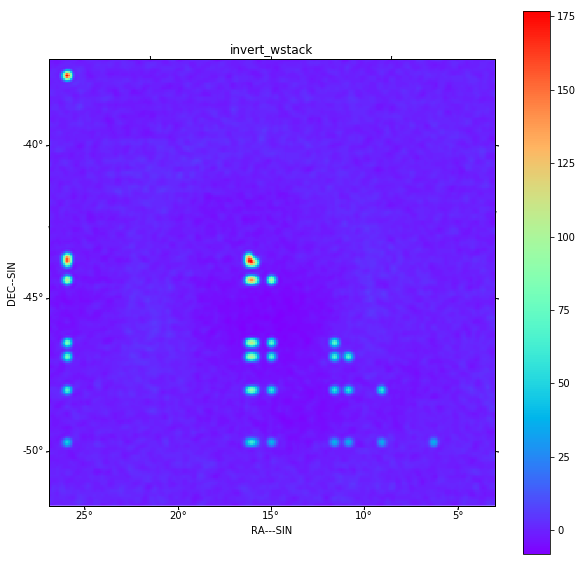

Dirty Image Quality assessment:
	Origin: qa_image
	Context: imaging-fits notebook, using processor invert_wstack
	Data:
		shape: (1, 1, 256, 256)
		max: 176.942261782
		min: -8.2528492451
		rms: 6.79097908817
		sum: 4324.43421513
		medianabs: 1.173162702
		median: -0.478378834297

find_skycomponents: Finding components in Image by segmentation
find_skycomponents: Identified 28 segments


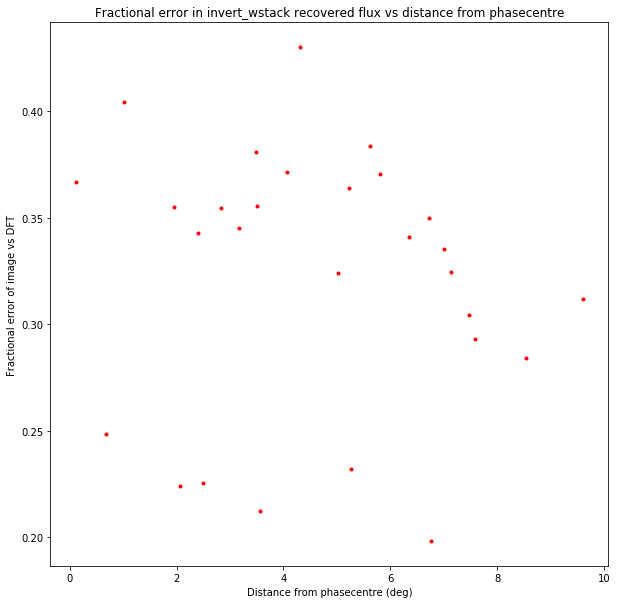

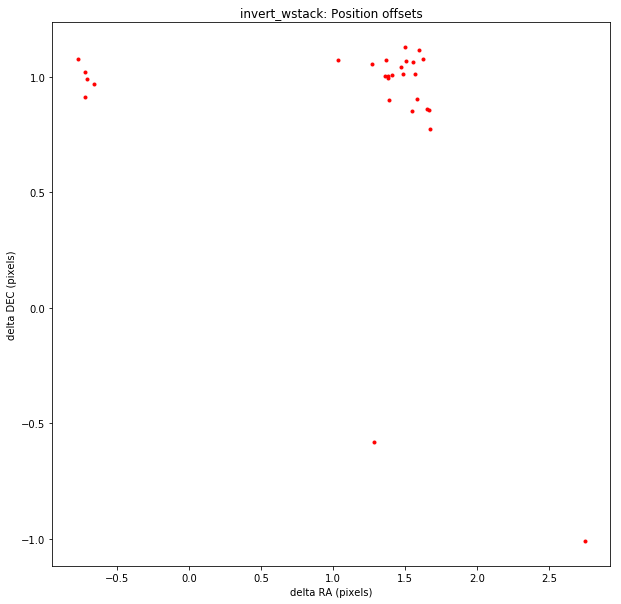

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>, starting frequency 100000000.0 Hz, and bandwidth 1000000.0 Hz
create_image_from_visibility: uvmax = 262.634709 wavelengths
create_image_from_visibility: Critical cellsize = 0.001904 radians, 0.109079 degrees
create_image_from_visibility: Cellsize          = 0.001000 radians, 0.057296 degrees
invert_2d: inverting using 2d transform
grid: 2.9024s
ifft: 0.0432s
func:'makeimage' took: 3.1379 sec


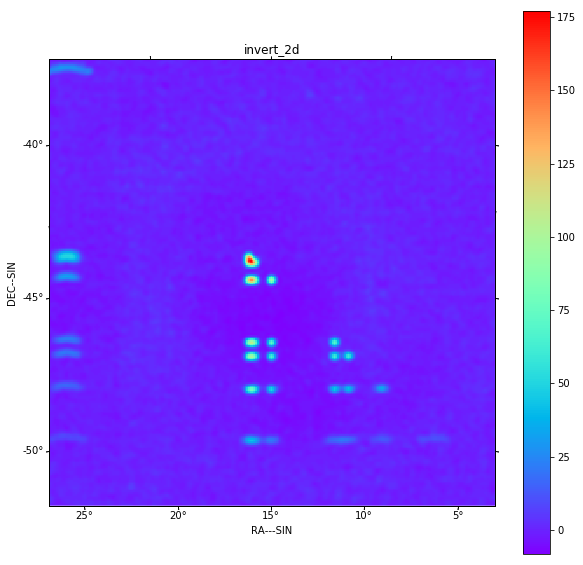

Dirty Image Quality assessment:
	Origin: qa_image
	Context: imaging-fits notebook, using processor invert_2d
	Data:
		shape: (1, 1, 256, 256)
		max: 177.131730377
		min: -8.24888308683
		rms: 5.80011862326
		sum: 3675.89350084
		medianabs: 1.17075318913
		median: -0.434224507435

find_skycomponents: Finding components in Image by segmentation
find_skycomponents: Identified 23 segments


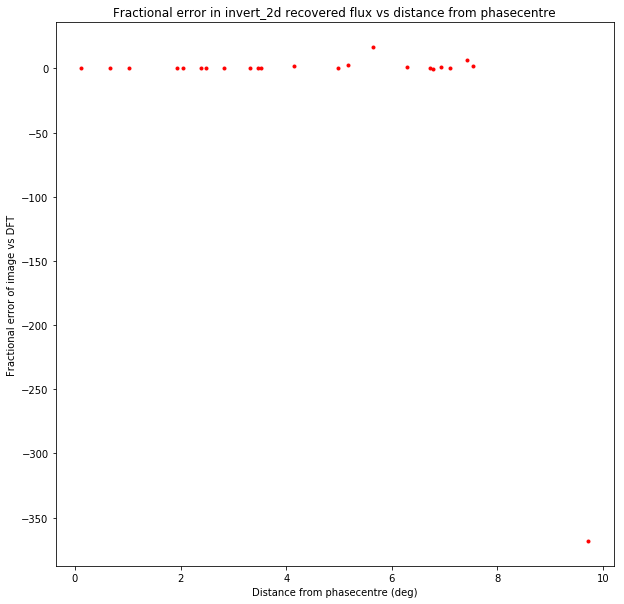

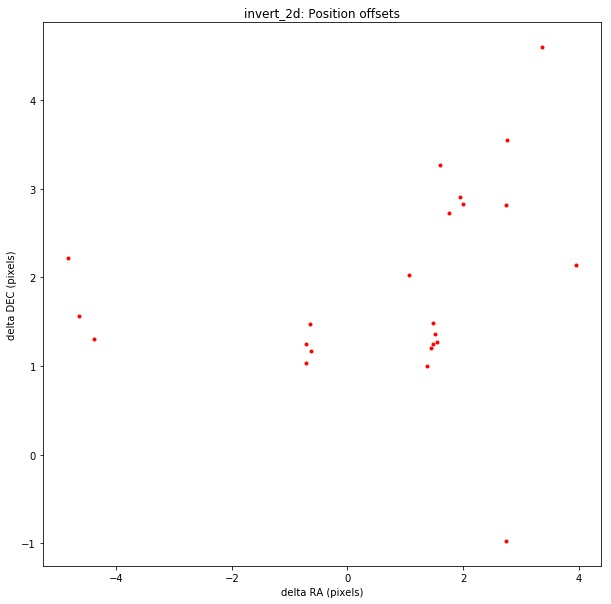

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>, starting frequency 100000000.0 Hz, and bandwidth 1000000.0 Hz
create_image_from_visibility: uvmax = 262.634709 wavelengths
create_image_from_visibility: Critical cellsize = 0.001904 radians, 0.109079 degrees
create_image_from_visibility: Cellsize          = 0.001000 radians, 0.057296 degrees
invert_timeslice: inverting using time slices
invert_timeslice_single: inverting using single time slice
fit_uvwplane: Fit to 13695 rows reduces rms w from 59.6 to 0.0 m
grid: 0.3095s
ifft: 0.0459s
invert_timeslice_single: inverting using single time slice
fit_uvwplane: Fit to 13695 rows reduces rms w from 46.1 to 0.0 m
grid: 0.3188s
ifft: 0.0532s
invert_timeslice_single: inverting using single time slice
fit_uvwplane: Fit to 13695 rows reduces rms w from 33.7 to 0.0 m
grid: 0.3126s
ifft: 0.0438s
invert_timesli

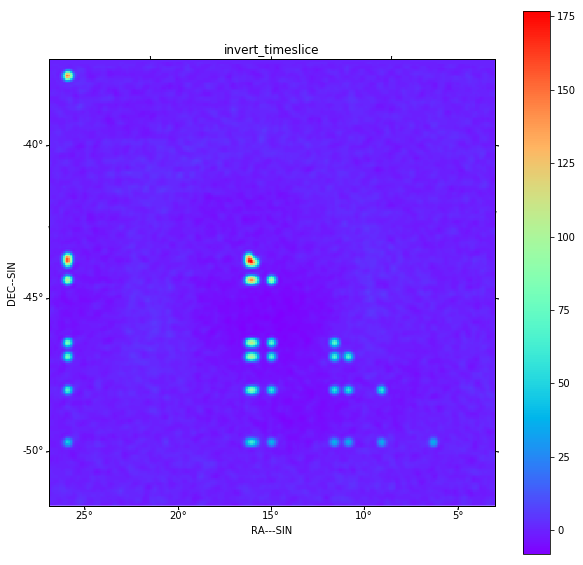

Dirty Image Quality assessment:
	Origin: qa_image
	Context: imaging-fits notebook, using processor invert_timeslice
	Data:
		shape: (1, 1, 256, 256)
		max: 176.951917449
		min: -8.25104665923
		rms: 6.69012601544
		sum: 4586.57579016
		medianabs: 1.13735487943
		median: -0.455833968747

find_skycomponents: Finding components in Image by segmentation
find_skycomponents: Identified 28 segments


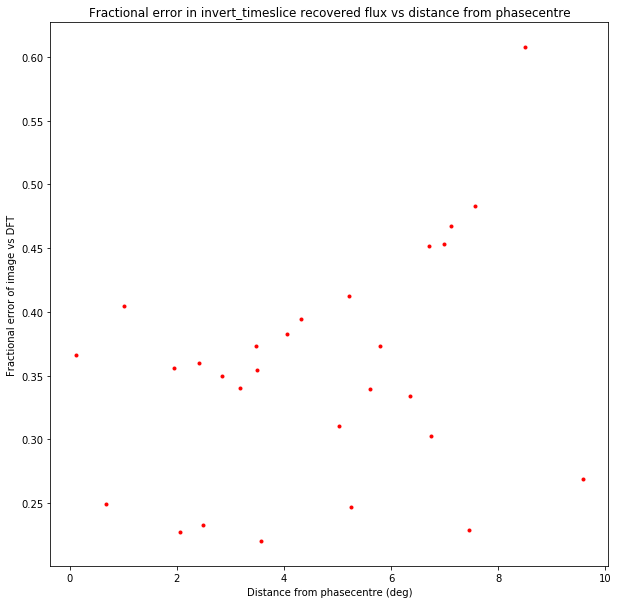

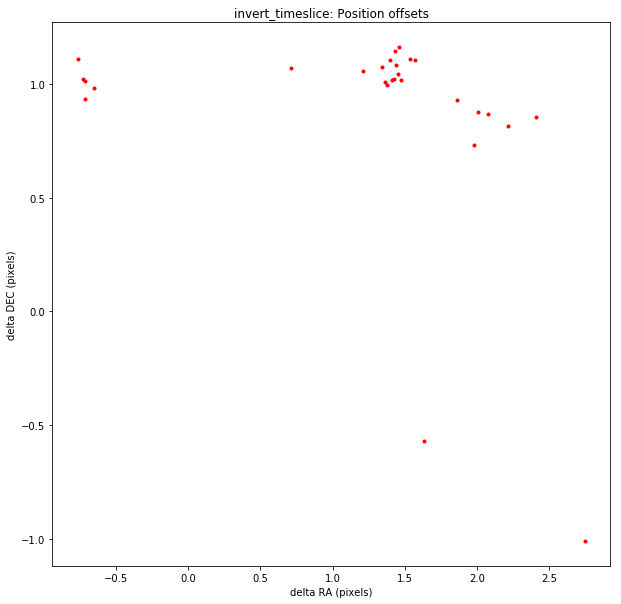

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>, starting frequency 100000000.0 Hz, and bandwidth 1000000.0 Hz
create_image_from_visibility: uvmax = 262.634709 wavelengths
create_image_from_visibility: Critical cellsize = 0.001904 radians, 0.109079 degrees
create_image_from_visibility: Cellsize          = 0.001000 radians, 0.057296 degrees
invert_facets: Inverting by image facets
invert_with_image_iterator: Inverting by image partitions
raster: predicting using 4 x 4 image partitions
raster: spacing of raster (64, 64)
raster: partition (0, 0) of (4, 4)
shift_vis_from_image: shifting phasecentre from vis phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)> to image phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 23.62802131, -50.21418966)>
grid: 2.1403s
ifft: 0.0026s
raster: partition (1, 0) of (4, 4)
shift_vis_from_image: shiftin

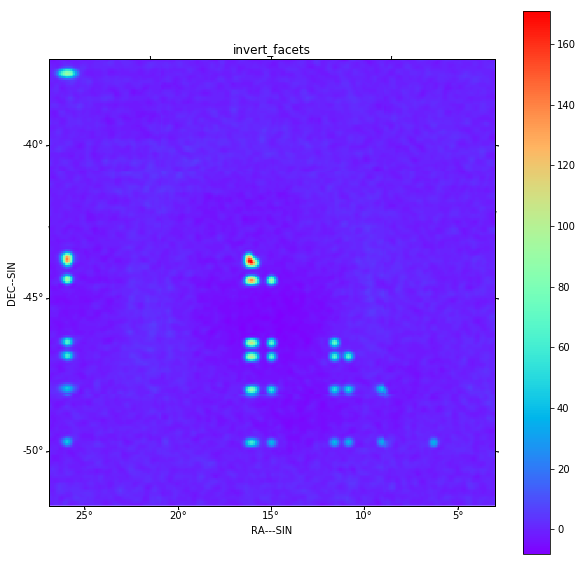

Dirty Image Quality assessment:
	Origin: qa_image
	Context: imaging-fits notebook, using processor invert_facets
	Data:
		shape: (1, 1, 256, 256)
		max: 170.962221625
		min: -8.22422081463
		rms: 6.42583201242
		sum: 4575.79566941
		medianabs: 1.17463072603
		median: -0.478021281733

find_skycomponents: Finding components in Image by segmentation
find_skycomponents: Identified 27 segments


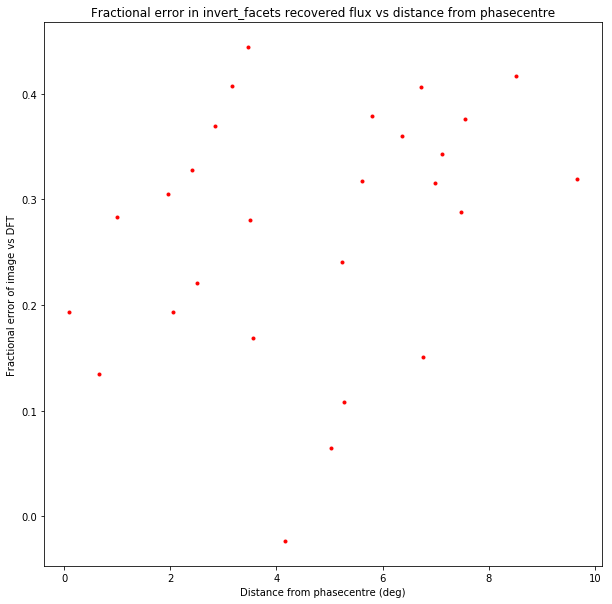

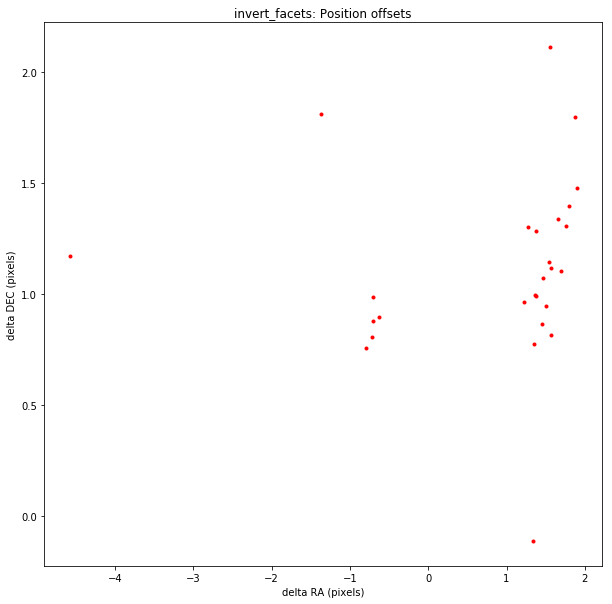

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>, starting frequency 100000000.0 Hz, and bandwidth 1000000.0 Hz
create_image_from_visibility: uvmax = 262.634709 wavelengths
create_image_from_visibility: Critical cellsize = 0.001904 radians, 0.109079 degrees
create_image_from_visibility: Cellsize          = 0.001000 radians, 0.057296 degrees
invert_2d: inverting using wprojection
get_kernel_list: Using wprojection kernel
get_kernel_list: Fresnel number = 16.384000
advise_wide_field: Maximum wavelength 2.998 (meters)
advise_wide_field: Minimum wavelength 2.998 (meters)
advise_wide_field: Maximum baseline 262.6 (wavelengths)
advise_wide_field: Station/antenna diameter 35.0 (meters)
advise_wide_field: Primary beam 0.085655 (rad) 4.908 (deg)
advise_wide_field: Image field of view 0.513930 (rad) 29.446 (deg)
advise_wide_field: Synthesized beam 0.003808 

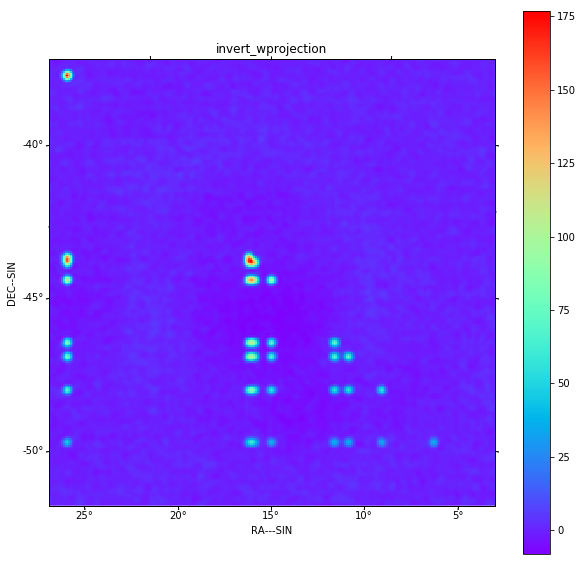

Dirty Image Quality assessment:
	Origin: qa_image
	Context: imaging-fits notebook, using processor invert_wprojection
	Data:
		shape: (1, 1, 256, 256)
		max: 176.960607803
		min: -8.25256856956
		rms: 6.78672160678
		sum: 4289.61261842
		medianabs: 1.17133999963
		median: -0.48019935645

find_skycomponents: Finding components in Image by segmentation
find_skycomponents: Identified 28 segments


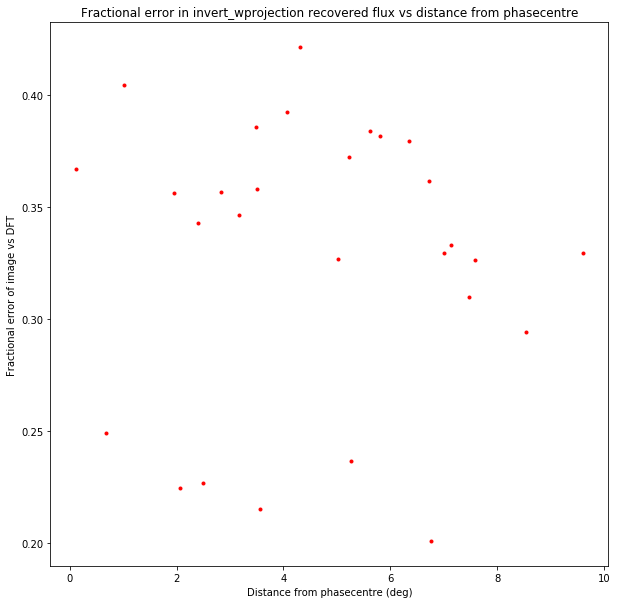

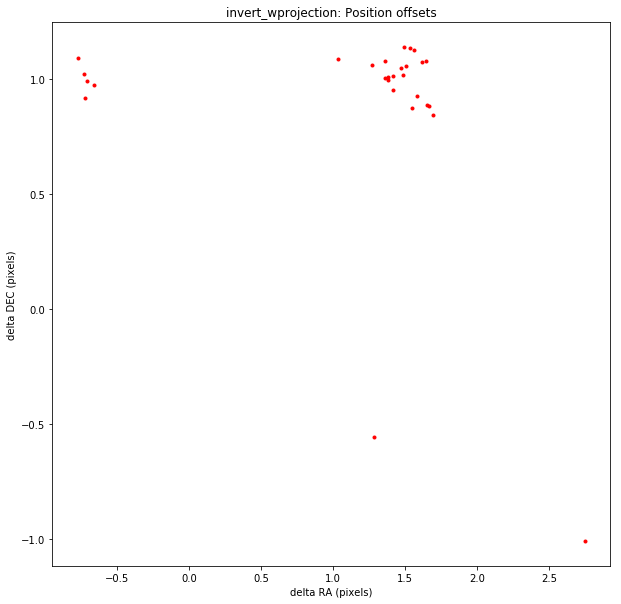

In [8]:
processors = [invert_wstack, invert_2d, invert_timeslice, invert_facets, invert_wprojection]

for processor in processors:

    targetimage = create_image_from_visibility(vt, npixel=npixel, cellsize=0.001, nchan=1,
                                              polarisation_frame=PolarisationFrame('stokesI'))
    @timing
    def makeimage():
        return processor(vt, targetimage, timeslice='auto', padding=2, oversampling=4,
                         facets=4, wstack=advice['w_sampling_primary_beam'], vis_slices=31,
                         wstep=advice['w_sampling_primary_beam'])
        
    targetimage, sumwt = makeimage()

    
    show_image(targetimage)
    plt.title(processor.__name__)
    plt.show()
    
    print("Dirty Image %s" % 
          qa_image(targetimage, context="imaging-fits notebook, using processor %s" %(processor.__name__)))
    
    export_image_to_fits(targetimage, '%s/imaging-fits_dirty_%s.fits' %(results_dir, processor.__name__))
    comps = find_skycomponents(targetimage, fwhm=1.0, threshold=10.0, npixels=5)

    plt.clf()
    for comp in comps:
        distance = comp.direction.separation(model.phasecentre)
        dft_flux = sum_visibility(vt, comp.direction)[0] 
        err = (comp.flux[0,0] - dft_flux ) / dft_flux
        plt.plot(distance, err, '.', color='r')
    plt.ylabel('Fractional error of image vs DFT')
    plt.xlabel('Distance from phasecentre (deg)')
    plt.title("Fractional error in %s recovered flux vs distance from phasecentre" % (processor.__name__))
    plt.show()

    checkpositions = True
    if checkpositions:
        plt.clf()
        for i in range(len(comps)):
            ocomp = find_nearest_component(comps[i].direction, original_comps)
            plt.plot((comps[i].direction.ra.value  - ocomp.direction.ra.value)/targetimage.wcs.wcs.cdelt[0], 
                     (comps[i].direction.dec.value - ocomp.direction.dec.value)/targetimage.wcs.wcs.cdelt[1], 
                     '.', color='r')  

        plt.xlabel('delta RA (pixels)')
        plt.ylabel('delta DEC (pixels)')
        plt.title("%s: Position offsets" % (processor.__name__))
        plt.show()